# Imports

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2 as cv
import os

# 1.1 Getting Correspondences
<p>We will be using the SIFT descriptor as it is able to do both Feature Extraction/Detection and Feature description, and from the feature descriptors, we can easily match the features. </p>

<p>We will apply the SIFT descriptor on the first frame of the book.mov and cv_cover.jpg. </p>

<h3> Few Notes</h3>

<p>In SIFT, we use gray-scale image, because SIFT heavily relies on gradient calculations to extract features like blobs, so SIFT just relies on intensity values and does not care about color. This also improves performance.</p> 
<p>So the gray-scale conversion is just to make the algorithm work efficiently and focus on structure (edges/corners), not color.</p>

<p>Gaussian Pyramid note:  
<ul>
<li>Multiple scales of image with one Gaussian sigma</li>
<li>is the same as multiple sigmas of gaussian on one scale of image</li>
</ul>
</p>

In [39]:
def read_image(image_relative_path):
    root = os.getcwd()
    imgPath = os.path.join(root, image_relative_path)
    
    # read image
    img = cv.imread(imgPath)
    
    return img

In [40]:
def get_frame(frame_num,capture):
    # set the frame position
    capture.set(cv.CAP_PROP_POS_FRAMES, frame_num)
    
    # read the frame
    ret, frame = capture.read()
    
    return ret, frame

In [41]:
def image2gray(image):
    return cv.cvtColor(image, cv.COLOR_BGR2GRAY)

In [42]:
def SIFT(image):

    # image in gray scale
    imgGray = image2gray(image)

    # create sift
    sift = cv.SIFT_create()

    # find keypoints and descriptors
    keypoints, descriptors = sift.detectAndCompute(imgGray, None)  # None is in place of a binary mask (none means don't exclude any pixels)

    # draw keypoints
    imgKeypoints = cv.drawKeypoints(imgGray, keypoints, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # show image
    plt.imshow(imgKeypoints)
    plt.axis('off')
    plt.title('SIFT Keypoints')
    plt.show()

    return keypoints, descriptors

In [43]:
def knnBruteForce(descriptor1,descriptor2):
    # create brute force matcher
    bf = cv.BFMatcher() # default match is L2 Distance, which is good for SIFT
    nNeighbors = 2
    matches = bf.knnMatch(descriptor1, descriptor2, k=nNeighbors) # get best 2 matches of each key-point is descriptor1
    # matches is best 2 matches in descriptor2 for each key-point in descriptor1

    nNeighbors = 2
    matches = bf.knnMatch(descriptor1, descriptor2, k=nNeighbors)

    goodMatches_50 = [None] * 50
    testRatio = 0.3
    i = 0
    for m, n in matches: # m is best match, and n is second best (m and n are keypoints in img2)
        if m.distance < testRatio * n.distance:
            goodMatches_50[i] = [m] # to drawMatchesKnn, it expects a list of lists of DMatch objects
            i+=1
            if i == 50: # we only want 50 matches
                print("Found 50 good matches")            
                break
    return goodMatches_50

def drawMatches(img1, img2, kp1, kp2, goodMatches):
    imgMatch = cv.drawMatchesKnn(
        img1, kp1, img2, kp2, goodMatches, None,
        flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    plt.figure()
    plt.imshow(imgMatch)
    plt.axis('off')
    plt.title('Matches')
    plt.show()



In [44]:
def knnBruteForce2a(descriptor1, kp1, descriptor2, kp2):
    # Create Brute-Force matcher with default settings (L2 norm for SIFT)
    bf = cv.BFMatcher()
    matches = bf.knnMatch(descriptor1, descriptor2, k=2)

    goodMatches = []
    src_pts = []  
    dst_pts = []
    testRatio = 0.3

    for m, n in matches:
        if m.distance < testRatio * n.distance:
            goodMatches.append(m)  # Just append the best match, not [m]
            src_pts.append(kp1[m.queryIdx].pt)  # Append the point from the first image
            dst_pts.append(kp2[m.trainIdx].pt)  # Append the point from the second image
            if len(goodMatches) == 50:
                print("Found 50 good matches")
                break

    # Extract corresponding points from the good matches
    # src_pts = np.float32([kp1[m.queryIdx].pt for m in goodMatches])
    # dst_pts = np.float32([kp2[m.trainIdx].pt for m in goodMatches])

    return goodMatches, src_pts, dst_pts



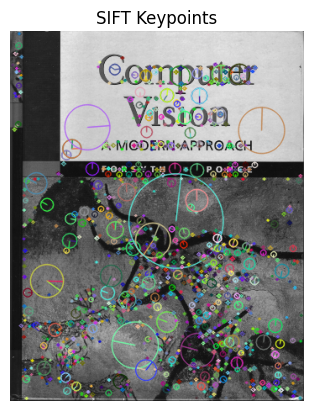

In [45]:
image1 = read_image('assignment_2_materials\\Part_1\\cv_cover.jpg')
keypoints1, descriptor1 = SIFT(image1)

In [46]:
# Load the video
cap = cv.VideoCapture('assignment_2_materials\\Part_1\\book.mov')
total_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
print(total_frames)

641


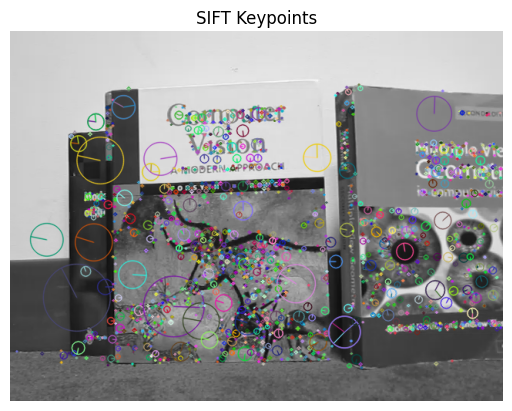

In [47]:
frame_num = 0
# Read the frame
ret, frame = get_frame(frame_num, cap)

if ret:
    keypoints2, descriptor2 = SIFT(frame)

Found 50 good matches
Found 50 good matches


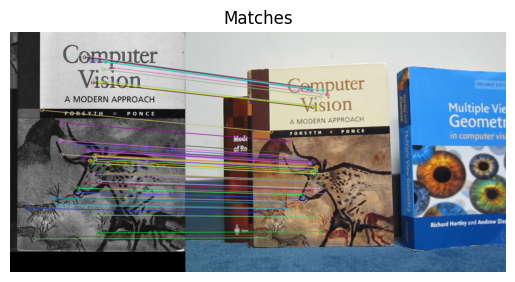

In [48]:
goodMatches1 ,kp1 ,kp2 = knnBruteForce2a(descriptor1, keypoints1 ,descriptor2, keypoints2)
coloredFrame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
goodMatches2 = knnBruteForce(descriptor1, descriptor2)
# drawMatches(image1, coloredFrame, keypoints1 , keypoints2, goodMatches1)
imgMatch = cv.drawMatches(image1, keypoints1, coloredFrame, keypoints2, goodMatches1, None,
                         flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure()
plt.imshow(imgMatch)
plt.axis('off')
plt.title('Matches')
plt.show()

# 1.2 Compute Homography Parameters

In [49]:
def compute_homography(src_pts, dst_pts):
    """
    Compute 3x3 homography matrix H such that dst = H * src
    Args:
        src_pts: List of source points [(x1, y1), (x2, y2), ...]
        dst_pts: List of destination points [(x1', y1'), (x2', y2'), ...]
    Returns:
        3x3 homography matrix
    """
    assert len(src_pts) >= 4 and len(src_pts) == len(dst_pts)

    # Convert to numpy arrays if they aren't already
    src_pts = np.array(src_pts, dtype=np.float64)   # Ensure float64 for precision
    dst_pts = np.array(dst_pts, dtype=np.float64)

    A = []
    for (x, y), (x_p, y_p) in zip(src_pts, dst_pts):    #zip pairs each src point with its matching dst point
        A.append([-x, -y, -1, 0, 0, 0, x*x_p, y*x_p])
        A.append([0, 0, 0, -x, -y, -1, x*y_p, y*y_p])

    A = np.array(A) # 2N* 8 matrix
    b = np.concatenate([dst_pts[:, 0], dst_pts[:, 1]])  # [x1',x2',...,y1',y2',...]

    # Solve using SVD for better numerical stability
    U, S, Vt = np.linalg.svd(A) # Singular Value Decomposition
    '''
    U: Left singular vectors (an orthogonal matrix)
    S: Singular values (diagonal matrix)(a vector of singular values )
    Vt: Right singular vectors (transpose)(transpose of an orthogonal matrix)
    '''
    H = Vt[-1, :] / Vt[-1, -1] #This computes the homography matrix H from the results of SVD
    '''
    Vt[-1, :]	Last singular vector -> solution of Ah = 0
    / Vt[-1, -1]	Normalize the vector to set H[2][2] = 1'''
    H = np.append(H, 1).reshape(3, 3) 
    return H

def verify_homography(H, src_pts, dst_pts):
    """Check how well H transforms src_pts to dst_pts"""
    src_hom = np.column_stack([src_pts, np.ones(len(src_pts))]) # Convert to homogeneous coordinates 3*1
    projected = (H @ src_hom.T).T #Applies the homography matrix H to the homogeneous source points
    projected /= projected[:, 2:]  # Normalize to get back to 2D coordinates
    
    errors = np.linalg.norm(projected[:, :2] - dst_pts, axis=1) # Calculate the Euclidean distance between projected points and actual destination points
    print(f"Mean reprojection error: {np.mean(errors):.2f} pixels")
    return errors

# Usage:
H = compute_homography(kp1, kp2)
errors = verify_homography(H, kp1, kp2)
H

Mean reprojection error: 14.96 pixels


array([[ 1.47285684e+03,  2.82155132e+02, -9.63158133e+04],
       [ 1.09574763e+03,  8.91964083e+02, -1.68341452e+05],
       [ 3.56538991e+00,  1.00000000e+00,  1.00000000e+00]])

In [50]:
def map_points(H, src_pts):
    """
    Maps points from src_pts (source points) to dst_pts (destination points)
    using the homography matrix H.
    """
    mapped_pts = []
    for pt in src_pts:
        pt_homogeneous = np.array([pt[0], pt[1], 1])  # Convert to homogeneous coordinates
        mapped_pt = H.dot(pt_homogeneous)  # Apply homography matrix
        mapped_pt = mapped_pt / mapped_pt[2]  # Convert back from homogeneous to non-homogeneous coordinates
        mapped_pts.append(mapped_pt[:2])  # Return only x, y coordinates
    return mapped_pts

MP = map_points(H, kp1)    
len(MP)

50

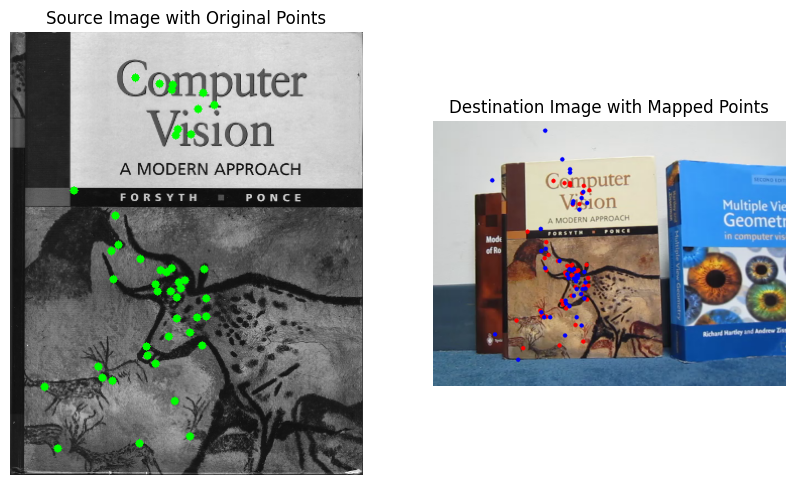

In [51]:
def draw_points(img, points, color=(0, 255, 0), radius=4):
    """
    Draw points on the image using OpenCV.
    """
    for pt in points:
        cv.circle(img, tuple(np.int32(pt)), radius, color, -1) #don't draw the circle outline

def visualize_mapping(img1, img2, src_pts, dst_pts, mapped_pts):
    """
    Visualize the mapped points from img1 to img2.
    """
    img1_copy = img1.copy()
    img2_copy = img2.copy()

    # Draw the original points on img1
    draw_points(img1_copy, src_pts, color=(0, 255, 0))  # Green for original points
    # Draw the destination points on img2
    draw_points(img2_copy, dst_pts, color=(255, 0, 0))  # Red for destination points
    # Draw the mapped points on img2
    draw_points(img2_copy, MP, color=(0, 0, 255))  # Blue for mapped points

    # Show the images
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img1_copy)
    plt.title('Source Image with Original Points')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2_copy)
    plt.title('Destination Image with Mapped Points')
    plt.axis('off')

    plt.show()

visualize_mapping(image1, coloredFrame, kp1, kp2, MP)

# 1.3 Calculate Book Coordinates

In [52]:
def detect_book_corners(book_cover, video_frame):
    """
    Detect book corners in a video frame using feature matching and homography
    
    Args:
        book_cover: The book cover image (template)
        video_frame: The video frame where to find the book
        feature_detector: 'SIFT' or 'ORB'
    
    Returns:
        corners: Detected corners in video frame [[x1,y1], [x2,y2], [x3,y3], [x4,y4]]
        visualization: Image with detected corners drawn
    """

    kp11 = np.float32(kp1).reshape(-1,1,2)
    kp22 = np.float32(kp2).reshape(-1,1,2)
    H, mask = cv.findHomography(kp11, kp22, cv.RANSAC, 5.0)
    
    # 7. Get book cover corners in video frame
    h, w = book_cover.shape[:2]
    cover_corners = np.float32([[0,0], [w-1,0], [w-1,h-1], [0,h-1]]).reshape(-1,1,2)
    video_corners = cv.perspectiveTransform(cover_corners, H)
    
    # 8. Convert to simple coordinate list
    corners = [np.int32(c[0]) for c in video_corners]
    
    # 9. Create visualization
    vis = cv.drawMatches(book_cover, keypoints1, video_frame, keypoints2, goodMatches1, None,
                         flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    # Draw quadrilateral around book
    for i in range(4):
        cv.line(vis, 
                (w + corners[i][0], corners[i][1]),
                (w + corners[(i+1)%4][0], corners[(i+1)%4][1]),
                (0,255,0), 3)
    
    return corners, vis,H
    
# Detect corners
corners, visualization , H= detect_book_corners(image1, frame)

print("Detected corners:")
for i, (x,y) in enumerate(corners):
    print(f"Corner {i+1}: ({x}, {y})")

# Show results
cv.imshow("Book Detection", visualization)
cv.waitKey(0)
cv.destroyAllWindows()

Detected corners:
Corner 1: (118, 77)
Corner 2: (403, 61)
Corner 3: (418, 429)
Corner 4: (124, 433)


In [53]:
def detect_book_corners(book_cover, video_frame, H,feature_detector='SIFT'):
    """
    Detect book corners in a video frame using feature matching and homography.
    
    Args:
        book_cover: Template image (the book cover)
        video_frame: Target frame to locate the book in
        feature_detector: 'SIFT' or 'ORB'
    
    Returns:
        corners: Transformed corner coordinates in video_frame
        vis: Visualization image showing matches + corner overlay
    """
    # 1. Initialize detector
    if feature_detector == 'SIFT':
        detector = cv.SIFT_create()
        matcher = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
    elif feature_detector == 'ORB':
        detector = cv.ORB_create()
        matcher = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    else:
        raise ValueError("Unsupported detector. Use 'SIFT' or 'ORB'.")

    # 2. Detect features
    # kp1, desc1 = detector.detectAndCompute(book_cover, None)
    # kp2, desc2 = detector.detectAndCompute(video_frame, None)

    # 3. Match features
    matches = matcher.match(descriptor1, descriptor2)
    good_matches = sorted(matches, key=lambda x: x.distance)[:50]

    # 4. Extract matched points
    # src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    # dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # 5. Find homography: from book_cover to video_frame
    # H, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)

    # 6. Map the four corners of the book_cover
    h, w = book_cover.shape[:2]
    corners_cover = np.float32([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]]).reshape(-1, 1, 2)
    corners_frame = cv.perspectiveTransform(corners_cover, H)
    corners = [tuple(map(int, pt[0])) for pt in corners_frame]  # list of (x, y)

    # 7. Draw matches between the two images
    vis = cv.drawMatches(book_cover, keypoints1, video_frame, keypoints2, good_matches, None,
                         flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # 8. Draw corners on the right image (video frame side)
    offset_x = w  # because right image starts after width of left image
    for i in range(4):
        pt1 = (offset_x + corners[i][0], corners[i][1])
        pt2 = (offset_x + corners[(i+1)%4][0], corners[(i+1)%4][1])
        cv.line(vis, pt1, pt2, (0, 255, 0), 3)

        # Optional: draw corner circles too
        cv.circle(vis, pt1, 5, (0, 0, 255), -1)  # Red dots at corners

    return corners, vis

corners ,visualization = detect_book_corners(image1, frame,H)
print("Book corners in frame:")
for i, (x, y) in enumerate(corners):
    print(f"Corner {i+1}: ({x}, {y})")

cv.imshow("Book Corners + Matches", visualization)
cv.waitKey(0)
cv.destroyAllWindows()


Book corners in frame:
Corner 1: (118, 77)
Corner 2: (403, 61)
Corner 3: (418, 429)
Corner 4: (124, 433)


In [54]:
# def detect_book_corners(book_cover, video_frame, H):
#     """
#     Detect and visualize book corners in a video frame using a homography matrix.

#     Args:
#         book_cover: Template image (the book cover)
#         video_frame: Target frame (e.g., from video)
#         H: Homography matrix from book_cover to video_frame

#     Returns:
#         corners: List of (x, y) points of detected corners in video_frame
#         vis: Side-by-side image showing only corner correspondences
#     """
#     h1, w1 = book_cover.shape[:2]
#     h2, w2 = video_frame.shape[:2]

#     # Resize video_frame to match height of book_cover for side-by-side display
#     if h1 != h2:
#         scale = h1 / h2
#         video_frame = cv.resize(video_frame, (int(w2 * scale), h1))
#         h2, w2 = video_frame.shape[:2]  # Update size

#     # 1. Define corners in book_cover
#     corners_cover = np.float32([[0, 0], [w1 - 1, 0], [w1 - 1, h1 - 1], [0, h1 - 1]]).reshape(-1, 1, 2)

#     # 2. Transform corners using homography
#     corners_frame = cv.perspectiveTransform(corners_cover, H)
#     corners = [tuple(map(int, pt[0])) for pt in corners_frame]

#     # 3. Create visualization image (side-by-side)
#     vis = np.hstack((book_cover, video_frame))
#     # offset_x = w  # right image starts after book_cover width

#     # 4. Draw only corner matches
#     # for i in range(4):
#     #     pt_cover = tuple(map(int, corners_cover[i][0]))  # Point in book_cover
#     #     pt_frame = tuple(map(int, corners_frame[i][0]))  # Transformed point in video_frame
#     #     pt_frame_offset = (pt_frame[0] + offset_x, pt_frame[1])

#     #     # Draw corner points
#     #     cv.circle(vis, pt_cover, 6, (0, 255, 0), -1)           # Green on book
#     #     cv.circle(vis, pt_frame_offset, 6, (0, 0, 255), -1)    # Red on frame

#     #     # Draw line between them
#     #     cv.line(vis, pt_cover, pt_frame_offset, (255, 0, 0), 2)

#     offset_x = w1  # because right image starts after width of left image
#     for i in range(4):
#         pt1 = (offset_x + corners[i][0], corners[i][1])
#         pt2 = (offset_x + corners[(i+1)%4][0], corners[(i+1)%4][1])
#         cv.line(vis, pt1, pt2, (0, 255, 0), 3)

#         # Optional: draw corner circles too
#         cv.circle(vis, pt1, 5, (0, 0, 255), -1)  # Red dots at corners

#     return corners, vis

# corners, visualization = detect_book_corners(image1, frame, H)

# print("Book corners in frame:")
# for i, (x, y) in enumerate(corners):
#     print(f"Corner {i+1}: ({x}, {y})")

# cv.imshow("Book Corners Only", visualization)
# cv.waitKey(0)
# cv.destroyAllWindows()
